<div class="alert alert-block alert-success">
<h1><b>PROJET 10 - </b>Développez une preuve de concept
</h1>
<h2>Notebook Scripts</h2></div>

<img src="img_notebook/logo_dataspace.png" width="350" height="350">

## Table of Contents<hr>
[INTRODUCTION & PRESENTATION](#section_0)<br>
&emsp;[A - IMPORTATIONS](#section_0A)<br>
&emsp;[B - DATA COLLECTION & DESCRIPTION](#section_0B)<br><hr>
[PART 1 - DATA PREPARATION](#section_1)<br>
&emsp;[A - DATA GENERATOR](#section_1A)<br>
&emsp;[B - PERFORMANCE METRICS](#section_1B)<br>
&emsp;&emsp;[1 - Intersection over Union (IoU)](#section_1B1)<br>
&emsp;&emsp;[2 - Dice Coefficient](#section_1B2)<br>
&emsp;&emsp;[3 - Performance metrics calculation functions](#section_1B3)<br>
&emsp;[C - LOSS FUNCTIONS](#section_1C)<hr>
[PART 2 - CONVOLUTIONAL NEURAL NETWORKS MODELS](#section_2)<br>
&emsp;&emsp;[1 - Presentation](#section_21)<br>
&emsp;&emsp;[2 - Utils functions to build the U-NET models](#section_22)<br>
&emsp;&emsp;[3 - Utils functions to visualize the training process](#section_23)<br>
&emsp;[A - U-NET HOMEMADE - BASELINE MODEL](#section_2A)<br>
&emsp;&emsp;[1 - Building the model](#section_2A1)<br>
&emsp;&emsp;[2 - Training and visualization with Dice Loss function</div></h4>](#section_2A2)<br>
&emsp;[B - STATE-OF-THE-ART MODEL](#section_2B)<br>
&emsp;&emsp;[1 - Building the model](#section_2B1)<br>
&emsp;&emsp;[2 - Training the model](#section_2B2)<br>
&emsp;&emsp;[3 - Visualization](#section_2B3)<br>
&emsp;[C - MODELS PERFORMANCE SUMMARY AND MODEL CHOICE](#section_2C)<br><hr>
[PART 3 - PART 3 - MASK PREDICTIONS](#section_3)<br>
&emsp;[A - SOME RANDOM MASK PREDICTIONS](#section_3A)<br>
&emsp;[B - WAYS TO IMPROVE THE RESULT](#section_3B)<br>

<h2><div class="alert alert-block alert-success" id="section_0">
INTRODUCTION & PRESENTATION</div></h2>

### Our mission

<b>Future Vision Transport</b> is a company that designs on-board computer vision systems for <b>autonomous vehicles</b>.

In the embedded computer vision system, we need to tackle the <b>image segmentation</b> part, which is fed by the image processing block and which feeds the decision system.

### Origin of the datasets

For this <b>semantic segmentation computer vision</b> challenge, we will use the <b>Cityscapes dataset</b> which focuses on semantic understanding of urban street scenes. This present a new large-scale dataset that contains a diverse set of stereo video sequences recorded in street scenes from 50 different cities, with high quality pixel-level annotations of <b>5 000 frames</b> in addition to a larger set of 20 000 weakly annotated frames.

We will use the 5 000 frames and the grouped classes into <b>8 main categories</b>, as follows.

#### • Class Definitions

|Group|Classes|
|---|---|
|<b>flat</b>|road · sidewalk · parking+ · rail track+|
|<b>human</b>|person* · rider*|
|<b>vehicle</b>|car* · truck* · bus* · on rails* · motorcycle* · bicycle* · caravan*+ · trailer*+|
|<b>construction</b>|building · wall · fence · guard rail+ · bridge+ · tunnel+|
|<b>object</b>|pole · pole group+ · traffic sign · traffic light|
|<b>nature</b>|vegetation · terrain|
|<b>sky</b>|sky|
|<b>void</b>|ground+ · dynamic+ · static+|

  \* *Single instance annotations are available. However, if the boundary between such instances cannot be clearly seen, the whole crowd/group is labeled together and annotated as group, e.g. car group.*
  <br>\+ *This label is not included in any evaluation and treated as void (or in the case of license plate as the vehicle mounted on).*

### What is semantic segmentation?

There are <b>three levels in the image analysis: Classification, Object detection and Segmentation</b>.<br><br>
<b>In semantic segmentation, each pixel is classified according to the class of the object it belongs to</b>. Here, we are talking about human, vehicule, constructon, sky, etc. Different objects of the same class are not distinguished (it's not instance segmentation).<br><br>
Image segmentation has many applications in medical imaging, <b>self-driving cars</b> (our case) and satellite imaging, just to name a few.<br>
Again, semantic segmentation is the task of classifying each pixel in an image from a predefined set of classes, and it's used by autonomous vehicles to understand their surroundings.<br>

### What sort of Machine Learning models are we going to use ?

<b>Deep learning</b> has worked comprehensively better than the previous existing techniques and has become a norm now when dealing with Semantic Segmentation.<br><br>
Actual contribution to the field has only been achieved very recently, particularly following a revolutionary paper on <b>fully convolutional networks (FCN)</b>. It could be said that most state-of-the-art studies are in fact extensions of that same study.<br>
Thus, we will train various deep learning semantic segmentation models, mainly around <b>U-NET</b> with <b>TensorFlow and Keras</b>.

<h3><div class="alert alert-block alert-info" id="section_0A">
A - IMPORTATIONS</div></h3>

In [1]:
%matplotlib inline

# Importation of Python modules and methods.
import os
import random
import warnings
from glob import glob
from math import ceil
from pprint import pprint

# Importation of Machine Learning libraries.
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Importation of an image segmentation third party library.
from segmentation_models.losses import dice_loss

# Importation of TensorFlow/Keras functions or classes.
from tensorflow.keras import backend as K
from tensorflow.keras import Input, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import (
    Activation, 
    BatchNormalization, 
    concatenate, 
    Conv2D,
    Conv2DTranspose, 
    Dropout, 
    MaxPooling2D 
)
from tensorflow.keras.models import Sequential, load_model
# from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import (
    img_to_array,
    load_img,
    plot_model, 
    Sequence,
)

warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'  # Only warning and error information is displayed.

Segmentation Models: using `keras` framework.


<h3><div class="alert alert-block alert-info" id="section_0B">
B - DATA COLLECTION & DESCRIPTION</div></h3>

The datasets we have, from Cityscapes, contain only <b>PNG images</b> with <b>size 1024 x 2048</b>.<br>
For <b>masks</b>, we are going to use the <b>gtFine_labelIds</b> ones.<br>
In total, we have <b>5 000 images</b> from different cities, and the same amount of respective masks.<br>
The directories and files are organized as follows:

#### Directory structure

```
datasets
│
└───images
│   │
│   └───test
│       └───berlin
│       |   └───berlin_000000_000019_leftImg8bit.png
│       |   └───berlin_000001_000019_leftImg8bit.png
│       |   └───...
│       └───bielefeld
│       └───...
│   └───train
│       └───...
│   └───val 
│       └───...
└───masks
    │
    └───test
        └───berlin
        |   └───berlin_000000_000019_gtFine_color.png
        |   └───berlin_000000_000019_gtFine_instanceIds.png
        |   └───berlin_000000_000019_gtFine_labelIds.png
        |   └───berlin_000000_000019_gtFine_polygons.json
        |   └───...
        └───bielefeld
        └───...
    └───train
        └───...
    └───val 
        └───...
```

In [2]:
def input_paths(_input='images', _type='train', is_aug=False):
    """Function to get the list of all images or masks collected 
    inside all the directories and sub-directories in the datasets, 
    excluding or not the augmented images."""
    if _input == 'images':
        if is_aug == True:
            input_paths_list = sorted(
                glob(f'datasets/{_input}/{_type}/**/*.png', recursive = True))
        elif is_aug == False:
            input_paths_list = sorted(
                glob(f'datasets/{_input}/{_type}/[!_]**/*.png', recursive = True))
    if _input == 'masks':
        # Getting only the labelIds masks (and the augmented masks if wanted).
        input_paths_list = sorted(
            glob(f'datasets/{_input}/{_type}/**/*gtFine_labelIds.png', recursive = True))
        if is_aug == True:
            aug_masks = sorted(
                glob(f'datasets/{_input}/{_type}/_data_aug/*.png', recursive = True))
            input_paths_list = sorted(input_paths_list + aug_masks)
    return input_paths_list

In [3]:
# Number of images, and examples, in the training dataset.
image_train_paths = input_paths(_input='images', _type='train')
print(f'\033[34;1mIn all directories the number of train images is \
{len(image_train_paths)}.\033[34;0m')
print('\n\033[34;1mFirst elements in image_train_paths list:\033[34;0m')
pprint(image_train_paths[:5])

# Number of masks, and examples, in the training dataset.
mask_train_paths = input_paths(_input='masks', _type='train')
print(f'\n\033[34;1mIn all directories the number of train masks is \
{len(mask_train_paths)}.\033[34;0m')
print('\n\033[34;1mFirst elements in mask_train_paths list:\033[34;0m')
pprint(mask_train_paths[:5])

In all directories the number of train images is 2975.

First elements in image_train_paths list:
['datasets/images/train/aachen/aachen_000000_000019_leftImg8bit.png',
 'datasets/images/train/aachen/aachen_000001_000019_leftImg8bit.png',
 'datasets/images/train/aachen/aachen_000002_000019_leftImg8bit.png',
 'datasets/images/train/aachen/aachen_000003_000019_leftImg8bit.png',
 'datasets/images/train/aachen/aachen_000004_000019_leftImg8bit.png']

In all directories the number of train masks is 2975.

First elements in mask_train_paths list:
['datasets/masks/train/aachen/aachen_000000_000019_gtFine_labelIds.png',
 'datasets/masks/train/aachen/aachen_000001_000019_gtFine_labelIds.png',
 'datasets/masks/train/aachen/aachen_000002_000019_gtFine_labelIds.png',
 'datasets/masks/train/aachen/aachen_000003_000019_gtFine_labelIds.png',
 'datasets/masks/train/aachen/aachen_000004_000019_gtFine_labelIds.png']


In [4]:
# Number of images, and examples, in the validation dataset.
image_val_paths = input_paths(_input='images', _type='val')
print(f'\033[34;1mIn all directories the number of validation images is \
{len(image_val_paths)}.\033[34;0m')
print('\n\033[34;1mFirst elements in image_val_paths list:\033[34;0m')
pprint(image_val_paths[:5])

# Number of masks, and examples, in the validation dataset.
mask_val_paths = input_paths(_input='masks', _type='val')
print(f'\n\033[34;1mIn all directories the number of validation masks is \
{len(mask_val_paths)}.\033[34;0m')
print('\n\033[34;1mFirst elements in mask_val_paths list:\033[34;0m')
pprint(mask_val_paths[:5])

In all directories the number of validation images is 500.

First elements in image_val_paths list:
['datasets/images/val/frankfurt/frankfurt_000000_000294_leftImg8bit.png',
 'datasets/images/val/frankfurt/frankfurt_000000_000576_leftImg8bit.png',
 'datasets/images/val/frankfurt/frankfurt_000000_001016_leftImg8bit.png',
 'datasets/images/val/frankfurt/frankfurt_000000_001236_leftImg8bit.png',
 'datasets/images/val/frankfurt/frankfurt_000000_001751_leftImg8bit.png']

In all directories the number of validation masks is 500.

First elements in mask_val_paths list:
['datasets/masks/val/frankfurt/frankfurt_000000_000294_gtFine_labelIds.png',
 'datasets/masks/val/frankfurt/frankfurt_000000_000576_gtFine_labelIds.png',
 'datasets/masks/val/frankfurt/frankfurt_000000_001016_gtFine_labelIds.png',
 'datasets/masks/val/frankfurt/frankfurt_000000_001236_gtFine_labelIds.png',
 'datasets/masks/val/frankfurt/frankfurt_000000_001751_gtFine_labelIds.png']


In [5]:
# Number of images, and examples, in the test dataset.
image_test_paths = input_paths(_input='images', _type='test')
print(f'\033[34;1mIn all directories the number of test images is \
{len(image_test_paths)}.\033[34;0m')
print('\n\033[34;1mFirst elements in image_test_paths list:\033[34;0m')
pprint(image_test_paths[:5])

# Number of masks, and examples, in the test dataset.
mask_test_paths = input_paths(_input='masks', _type='test')
print(f'\n\033[34;1mIn all directories the number of test masks is \
{len(mask_test_paths)}.\033[34;0m')
print('\n\033[34;1mFirst elements in mask_test_paths list:\033[34;0m')
pprint(mask_test_paths[:5])

In all directories the number of test images is 1525.

First elements in image_test_paths list:
['datasets/images/test/berlin/berlin_000000_000019_leftImg8bit.png',
 'datasets/images/test/berlin/berlin_000001_000019_leftImg8bit.png',
 'datasets/images/test/berlin/berlin_000002_000019_leftImg8bit.png',
 'datasets/images/test/berlin/berlin_000003_000019_leftImg8bit.png',
 'datasets/images/test/berlin/berlin_000004_000019_leftImg8bit.png']

In all directories the number of test masks is 0.

First elements in mask_test_paths list:
[]


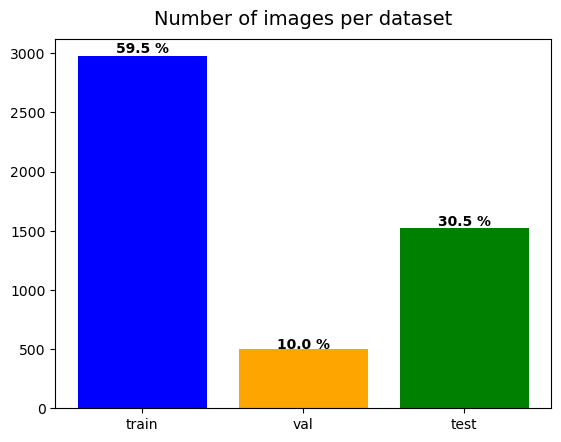

In [6]:
# Bar plot of the number of images per type of dataset.
fig, ax = plt.subplots()
images_cat = ['train', 'val', 'test']
images_num = [len(image_train_paths), 
              len(image_val_paths), 
              len(image_test_paths)]
colors_list = ['blue', 'orange', 'green']
images = plt.bar(images_cat, images_num, color=colors_list)
for img in images:
    height = img.get_height()
    width = img.get_width()
    x, y = img.get_xy()
    ax.text(x + width / 2, y + height * 1.01,
            s=f"{height * 100 / sum(images_num)} %", 
            ha='center', weight='bold')
plt.title('Number of images per dataset', size=14, pad=10)
plt.show()

Image shape: (1024, 2048, 3)
Mask shape: (1024, 2048)


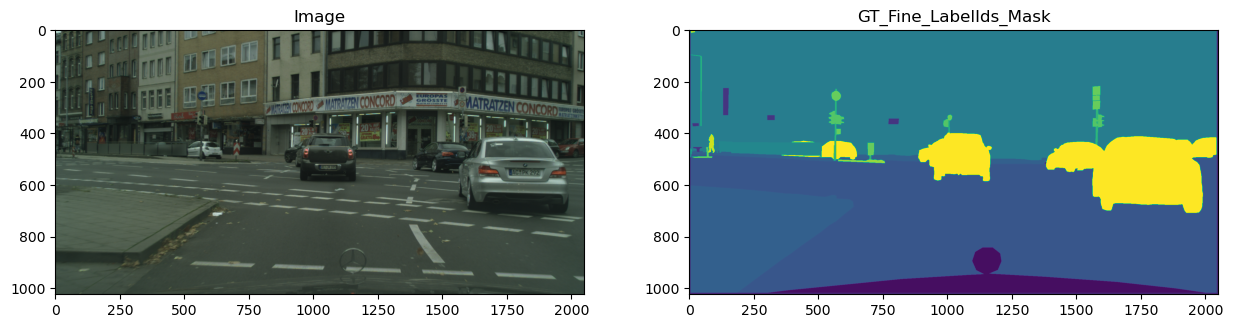

In [7]:
# Visualizing an image and its mask.
i = 3
test_image = img_to_array(
    load_img(image_train_paths[i])) / 255.0
test_mask = img_to_array(
    load_img(mask_train_paths[i], color_mode="grayscale"))
test_mask = np.squeeze(test_mask)

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 2, 1)
ax.set_title('Image')
ax.imshow(test_image)

ax1 = fig.add_subplot(1, 2, 2)
ax1.set_title('GT_Fine_LabelIds_Mask')
ax1.imshow(test_mask)

# Checking the shape of the image and the mask.
print(f"\033[34;1mImage shape: {test_image.shape}")
print(f"Mask shape: {test_mask.shape}")

<h2><div class="alert alert-block alert-success" id="section_1">
PART 1 - DATA PREPARATION</div></h2>

<h3><div class="alert alert-block alert-info" id="section_1A">
A - DATA GENERATOR</div></h3>

The <b>manipulation of a large dataset</b> will be easier with the construction of a data generator as a python class. This reduce the need of high memory space. This generator creates data in batches to feed it to our network for training.<br><br>
For that, we will use the <b>*Sequence* class in Keras</b>, that handles all the multi-threading and parallelization behind the scene by fetching the batches ahead of time using multiple CPU cores.<br>
It generates the dataset on multiple cores in real time and feed it right away to our deep learning models.

In [8]:
# Defining variables for the rest of the modelling.
batch_size = 32   # for training and validation.
IMG_HEIGHT = 256  # instead of the original 1024, to reduce time complexity.
IMG_WIDTH = 512   # instead of the original 2048, to reduce time complexity.
IMG_CHANNELS = 3  # RGB
n_classes = 8     # class colors.
num_filters = 32  # for later, for modelling our homemade U-NET model.

In [9]:
# Dict of the 8 categories, as keys, and a list of corresponding class ids as values.
cat_dict = {'void': [0, 1, 2, 3, 4, 5, 6], 
            'flat': [7, 8, 9, 10],
            'construction': [11, 12, 13, 14, 15, 16],
            'object': [17, 18, 19, 20],
            'nature': [21, 22],
            'sky': [23],
            'human': [24, 25],
            'vehicle': [26, 27, 28, 29, 30, 31, 32, 33, -1]  # -1 is for the license plate.
           }

In [10]:
class ImgSeqGenerator(Sequence):
    """Helper to iterate over the data, to load & vectorize batches of data.
    """

    def __init__(self, x_set, y_set, batch_size, n_classes=8, shuffle=False):
        """Generator constructor: parameters."""
        self.x_set = x_set
        self.y_set = y_set
        self.batch_size = batch_size
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        """Number of batches that this generator is supposed to produce, per epoch."""
        return ceil(len(self.x_set) / self.batch_size)

    def on_epoch_end(self):
        """Updates indexes after each epoch."""
        self.indexes = np.arange(len(self.x_set))
        if self.shuffle == True:
            np.random.seed(53)
            np.random.shuffle(self.indexes)
    
    def __getitem__(self, idx):  # allows the instance to use the [] (indexer) operator.
        """Returns tuple (image, mask) corresponding to batch number.
        Generating one batch of data."""
        # Batch size list of random integers in the range of the size of the image list length.
        current_batch_id = self.indexes[idx * self.batch_size: (idx + 1) * self.batch_size]
        batch_x, batch_y = [], []
        # Generating batch_x and batch_y.
        # Iterate over indexes.
        for i in current_batch_id:
            # Loading image, setting target size, converting to array and normalizing. 
            _image = img_to_array(
                load_img(f'{self.x_set[i]}', target_size=(
                    IMG_HEIGHT, IMG_WIDTH))) / 255.
            # Storing image.
            batch_x.append(_image)
            # Loading original mask, setting target size and converting to array. 
            msk = img_to_array(
                load_img(f'{self.y_set[i]}', color_mode="grayscale", target_size=(
                    IMG_HEIGHT, IMG_WIDTH)))
            msk = np.squeeze(msk, axis=-1)
            mask = np.zeros((msk.shape[0], msk.shape[1], self.n_classes))
            # Transforming the 34 original classes from the original mask to 8 categories.
            for j in range(-1, 34):
                if j in cat_dict['void']:
                    mask[:, :, 0] = np.logical_or(mask[:, :, 0], (msk == j))
                elif j in cat_dict['flat']:
                    mask[:, :, 1] = np.logical_or(mask[:, :, 1], (msk == j))
                elif j in cat_dict['construction']:
                    mask[:, :, 2] = np.logical_or(mask[:, :, 2], (msk == j))
                elif j in cat_dict['object']:
                    mask[:, :, 3] = np.logical_or(mask[:, :, 3], (msk == j))
                elif j in cat_dict['nature']:
                    mask[:, :, 4] = np.logical_or(mask[:, :, 4], (msk == j))
                elif j in cat_dict['sky']:
                    mask[:, :, 5] = np.logical_or(mask[:, :, 5], (msk == j))
                elif j in cat_dict['human']:
                    mask[:, :, 6] = np.logical_or(mask[:, :, 6], (msk == j))
                elif j in cat_dict['vehicle']:
                    mask[:, :, 7] = np.logical_or(mask[:, :, 7], (msk == j))
            mask = np.resize(mask, (IMG_HEIGHT, IMG_WIDTH, self.n_classes))
            # Storing mask.
            batch_y.append(mask)

        return np.array(batch_x), np.array(batch_y)

In [11]:
# Generators for training and validation data.
# Creating instances of the ImgSeqGenerator class.
train_generator = ImgSeqGenerator(
    image_train_paths, mask_train_paths, batch_size, shuffle=True)
val_generator = ImgSeqGenerator(
    image_val_paths, mask_val_paths, batch_size, shuffle=True)

In [12]:
print(f"Number of batches of {batch_size} training images: \
{len(train_generator)}")
print(f"Number of batches of {batch_size} validation images: \
{len(val_generator)}")

Number of batches of 32 training images: 93
Number of batches of 32 validation images: 16


In [13]:
# Checking data shape of the first training batch.
x_train, y_train = train_generator[0]
print('Data shape of the first training batch (x and y): ', x_train.shape, y_train.shape)

Data shape of the first training batch (x and y):  (32, 256, 512, 3) (32, 256, 512, 8)


In [14]:
# Checking data shape of the last training batch.
x_train, y_train = train_generator[92]
print('Data shape of the last training batch (x and y): ', x_train.shape, y_train.shape)

Data shape of the last training batch (x and y):  (31, 256, 512, 3) (31, 256, 512, 8)


In [15]:
# Checking data shape of the first validation batch.
x_val, y_val = val_generator[0]
print('Data shape of the first validation batch (x and y): ', x_val.shape, y_val.shape)

Data shape of the first validation batch (x and y):  (32, 256, 512, 3) (32, 256, 512, 8)


In [16]:
# Checking data shape of the last validation batch.
x_val, y_val = val_generator[15]
print('Data shape of the last validation batch (x and y): ', x_val.shape, y_val.shape)

Data shape of the last validation batch (x and y):  (20, 256, 512, 3) (20, 256, 512, 8)


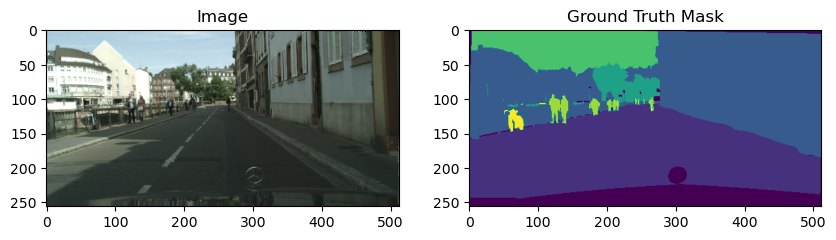

In [17]:
# Getting the first image and ground truth mask from the training data.
x_train, y_train = train_generator[0]
img = x_train[0]
mask = y_train[0]

# Converting the one-hot encoded mask back to its class label form.
mask = np.argmax(mask, axis=-1)

# Plotting the image and ground truth mask.
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img)
ax[0].set_title('Image')
ax[1].imshow(mask)
ax[1].set_title('Ground Truth Mask')
plt.show()

<h3><div class="alert alert-block alert-info" id="section_1B">
B - PERFORMANCE METRICS</div></h3>

<b>To evaluate the performance of the Deep Learning models</b> we are going to build for <b>Semantic Segmentation</b>, we will use 2 different metrics, both quite similar.<br>
Then, we will keep only one to compare all the models (and not wasting time).

Our prediction output shape, the mask, matches the input's spatial resolution (width and height) with a channel depth equivalent to the number of possible classes to be predicted. Each channel consists of a binary mask which labels areas where a specific class is present.

<b>Accuracy is here irrelevant</b>. Pixel accuracy can provide misleading results when the class representation is small within the image, as the measure will be biased in mainly reporting how well you identify negative case (ie. where the class is not present).

Instead, we will use here the <b>IoU and the Dice Coefficient</b> that suit better for semantic segmentation.

<h4><div class="alert alert-block alert-warning" id="section_1B1">
1 - Intersection over Union (IoU)</div></h4>

<b>The Intersection over Union (IoU), or the Jaccard index</b>, quantifies the percent overlap between the target mask and our prediction output.<br>Said another way, it is <b>the ratio of the intersection of the pixelwise classification results with the ground truth (the mask), to their union</b>.

The IoU score is calculated for each class separately and then averaged over all classes to provide a global, <b>mean IoU score</b> of our semantic segmentation prediction. In fact, <b>we will use this only metric during training to compare all the models</b>.

This metric ranges from 0–1 (0–100%) with 0 signifying no overlap and 1 signifying perfectly overlapping segmentation.

<img src="img_notebook/IoU.png" width="350" height="350">

#### • Formula:

<img src="img_notebook/IoU_formula.png" width="350" height="350">

<h4><div class="alert alert-block alert-warning" id="section_1B2">
2 - Dice Coefficient</div></h4>

The <b>Sørensen–Dice coefficient or Dice Coefficient</b> is simply the count of the similar pixels (taking intersection, present in both images) in both images we are comparing and multiplied by 2, the total divided by the total pixels in both images.<br>
Or, to put it simply, it's 2 * the Area of Overlap divided by the total number of pixels in both images.

As for IoU, this metric ranges from 0–1 (0–100%) with 0 signifying no overlap and 1 signifying perfectly overlapping segmentation.

<img src="img_notebook/Dice.png" width="300" height="300">

#### • Formula:

<img src="img_notebook/Dice_formula.png" width="200" height="200">

This metric is <b>closely related to the IoU coefficient</b> we just saw.<br>
Here <b>we will also use this metric in the loss function during training</b>.

<h4><div class="alert alert-block alert-warning" id="section_1B3">
3 - Performance metrics calculation functions</div></h4>

In [18]:
def iou_coef(y_true, y_pred, smooth=0.001):
    """IoU coefficient calculation."""
    y_pred_f = K.flatten(y_pred)
    y_true_f = K.flatten(y_true)
    intersection = K.sum(y_true_f * y_pred_f)
    mask_sum = K.sum(y_true_f) + K.sum(y_pred_f)
    union = mask_sum - intersection
    iou_coef = (intersection + smooth) / (union + smooth)  # smooth to avoid division by 0.
    return iou_coef

In [19]:
def dice_coef(y_true, y_pred, smooth=0.001):
    """Dice coefficient calculation."""
    y_pred_f = K.flatten(y_pred)
    y_true_f = K.flatten(y_true)
    intersection = K.sum(y_true_f * y_pred_f)
    mask_sum = K.sum(y_true_f) + K.sum(y_pred_f)
    dice_coef = ((2 * intersection) + smooth) / (mask_sum + smooth)
    return dice_coef

<h3><div class="alert alert-block alert-info" id="section_1C">
C - LOSS FUNCTIONS</div></h3>

For the <b>loss function</b>, crucial for the models to be able to learn well, <b>we will try different ones<b>.

First, the obvious one is the cross entropy loss function that examines each pixel individually, comparing the class predictions (depth-wise pixel vector) to our one-hot encoded target vector. But, this can be a problem if the various classes have unbalanced representation in the image, which is the case here.<br><br>
The <b>categorical focal loss</b> works better here, as it's better on hard examples and thus better on problem of class imbalance.<br><br>
We will also use the <b>Dice loss</b> because it performs well at class imbalanced problems by design, instead of the categorical cross entropy that can be seen more as a proxy, easier to maximize. It's based on the Dice coefficient, using 1 - Dice to minimize.<br><br>
With the same idea, we'll try the <b>IoU or Jaccard loss</b>, a.k.a 1 - Jaccard.<br><br>
Finally, we will try <b>a mix of the categorical focal loss and the Dice loss</b>.<br>

As an hyperparameter tuning work, <b>we will test all these loss functions and finally choose one to train all the models with</b>.

<h2><div class="alert alert-block alert-success" id="section_2">
PART 2 - FULLY CONVOLUTIONAL NEURAL NETWORKS MODELS</div></h2>

<h4><div class="alert alert-block alert-warning" id="section_21">
1 - Presentation</div></h4>

To deal with this semantic segmentation challenge, <b>we are going to use Convolutional Neural Networks models, and more specifically U-NET models</b>, which are Encoder-Decoder models. 

The U-Net is a convolutional network architecture, designed by Olaf Ronneberger, Philipp Fischer and Thomas Brox, for biomedical image segmentation, at the Computer Science Department of the University of Freiburg.<br><b>U-NET is based upon the "fully convolutional" architecture</b>, and "consists of a contracting path to capture context and a symmetric expanding path that enables precise localization." Why a FCN ? Because for problems where object location matters, densely connected features are largely useless. These Dense or Flatten layers get rid of the notion of space.

More precisely, a U-Net consists of an encoder which downsamples an image to an encoding (the lefthand side of architecture), and a mirrored decoder which upsamples the encoding back to the desired mask (the righthand side of the architecture). The contracting path is a typical convolutional network that consists of repeated application of convolutions, each followed by a rectified linear unit (ReLU) and a max pooling operation. During the contraction, the spatial information is reduced while feature information is increased. The decoder blocks have a number of skip connections (depicted by the horizontal arrows in the center) that directly connect from the encoder blocks. These skip connections copy features at a specific resolution and concatenate them channel-wise with specific feature maps in the decoder. This brings information at various levels of semantic granularity from the encoder directly into the decoder. After concatenating the feature maps from the contracting path onto the expanding path, a subsequent convolutional layer allows the network to learn to assemble and localize these features precisely. The final result is a network that is highly adept both at identifying features and at locating those features within two-dimensional space.

The original U-Net uses all convolutions without padding, which means that border pixels are lost at each layer.<br>
The original U-Net proposed by the authors already used Transpose Convolutions for upsampling the feature maps.

<b>In short, in the downslope of the U-NET (contracting path), the network learns to classify the objects with the features found.<br>
In the upslope (expansive path) the network try to localize the objects in the picture</b>.

Pooling layers helps the architecture create feature hierarchies, but also causes loss of localized information. Skip connections preserve and forward this information to deeper layers by way of bypassing the pooling layers.

<h4><div class="alert alert-block alert-warning" id="section_22">
2 - Utils functions to build the U-NET models</div></h4>

#### These helper functions allow us to ensemble our model block operations easily and simply.

In [20]:
def encoder_block(input_tensor, num_filters, 
                  kernel_init='he_normal', pooling=True):
    """Encoder block: 1 convolutional layer, 1 batch normalization, 1 convolutional layer,
    1 batch normalization and 1 max pooling layer (or not if it's the last encoder layer).
    """
    conv = Conv2D(filters=num_filters, kernel_size=(3, 3), strides=(1, 1),
                  padding='same', use_bias=False, kernel_initializer=kernel_init)(input_tensor)
    # BatchNormalization is good for standardizing, stabilizing, speeding up the training
    # and reducing generalization error. No need of dropout anymore. No need of bias vector.
    conv = BatchNormalization()(conv)
    conv = Activation('relu')(conv)
    conv = Conv2D(num_filters, (3, 3),  padding='same', use_bias=False, 
                  kernel_initializer=kernel_init)(conv)
    conv = BatchNormalization()(conv)
    conv = Activation('relu')(conv)
    if pooling == True:
        pool = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(conv)
        return pool, conv
    return conv

def decoder_block(input_tensor, num_filters, concat_tensor, 
                  dropout=0.1, kernel_init='he_normal'):
    """Decoder block: 1 transposed convolution layer (with concatenation for skip connections), 
    1 convolutional layer, 1 dropout and 1 convolutional layer.
    """
    decoder = Conv2DTranspose(filters=num_filters, kernel_size=(2, 2), 
                              strides=(2, 2), padding='same')(input_tensor)  # strides are here stretching size.
    decoder = concatenate([decoder, concat_tensor])
    decoder = Conv2D(filters=num_filters, kernel_size=(3, 3), 
                     strides=(1, 1), padding='same', 
                     activation='relu', kernel_initializer=kernel_init)(decoder)
    decoder = Dropout(rate=dropout, seed=52)(decoder)
    decoder = Conv2D(num_filters, (3, 3), activation='relu', 
                     kernel_initializer=kernel_init, 
                     padding='same')(decoder)
    return decoder

#### Training function to train, compile, make callbacks, fit and save models.

In [21]:
def training_model(model,
                   name, 
                   train_gen=train_generator, 
                   val_gen=val_generator, 
                   optimizer='adam', 
                   loss=dice_loss,
                   metrics=['accuracy']):
    
    """Configuring the model for training. Compiling, callbacks, fitting and saving.
    """
    # Configuring the model for training.
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    # Defining EarlyStopping callback.
    earlystop = EarlyStopping(monitor='val_loss', patience=2,
                              restore_best_weights=True)
    # Defining ModelCheckpoint callback. Best weights are saved at the end of every epoch, 
    # if it's the best seen so far.
    checkpoint_path = f"checkpoint/{name}"
    checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                                 monitor='val_loss',
                                 save_weights_only=True)

    print(f"\033[34;1mTraining the model named '{name}':\n\033[34;0m")

    # Training the model, doing validation at the end of each epoch.
    # We use here fit() with a generator to deal with huge dataset that 
    # couldn't fit into memory.
    hist_model = model.fit(x=train_gen, 
                           epochs=25, 
                           verbose=2, 
                           callbacks=[earlystop, checkpoint], 
                           validation_data=val_gen, 
                           steps_per_epoch=len(train_gen), 
                           validation_steps=len(val_gen),
                           workers=10)  # use_multiprocessing not working !
    
    # Saving the entire model as a SaveModel. This saves the model architecture, weights,
    # information about the training process such as the state of the optimizer, etc.
    model.save(f"models/{name}")
    
    return hist_model

<h4><div class="alert alert-block alert-warning" id="section_23">
3 - Utils functions to visualize the training process</div></h4>

#### Function to vizualize performance metrics evolution.

In [22]:
def metrics_visu(hist, metric_name):
    """Visualization of the Training and Validation with the selected metric."""
    metric = hist.history[metric_name]
    val_metric = hist.history[f'val_{metric_name}']
    epochs = range(1, len(metric) + 1)

    plt.plot(epochs, metric, '-', label=f'Training {metric_name}')
    plt.plot(epochs, val_metric, ':', label=f'Validation {metric_name}')
    plt.title(f'Training and Validation {metric_name} performance metric')
    plt.xlabel('Epoch')
    plt.ylabel(metric_name)
    plt.legend()
    plt.show()

#### Function to vizualize loss function evolution.

In [23]:
def loss_visu(hist, loss_name):
    """Visualization of the Training and Validation with the selected Loss function."""
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    epochs = range(1, len(loss) + 1)

    plt.plot(epochs, loss, '-', label=f'Training {loss_name}')
    plt.plot(epochs, val_loss, ':', label=f'Validation {loss_name}')
    plt.title(f'Training and Validation {loss_name} loss function')
    plt.xlabel('Epoch')
    plt.ylabel(loss_name)
    plt.legend()
    plt.show()

<h3><div class="alert alert-block alert-info" id="section_2A">
A - U-NET HOMEMADE - BASELINE MODEL</div></h3>

<b>U-Net</b> is especially good with segmentation tasks because it can localize well to <b>provide high resolution segmentation masks</b>. In addition, it works well with small datasets and is <b>relatively robust against overfitting</b> as the training data is in terms of the number of patches within an image, which is much larger than the number of training images itself.

For upsampling, U-NET models use transposed convolutional layers. This is equivalent to first stretching the image by inserting empty rows and columns (full of zeros), then performing a regular convolution. These are also trainable layers.

One of the changes, from the original architecture, that will be included in this structure is using the value of <b>padding as "same"</b>.<br>
Also, since the concept of <b>batch normalization</b> was introduced in 2016, the original architecture did not use this aspect. But, our model implementation will include batch normalization as it yields the best results in most cases.

Ensure that your <b>image shapes</b> are <b>divisible by at least 16</b>. Since we are using four max-pooling layers during the down-sampling procedure, we don't want to encounter the divisibility of any odd number shapes.

#### Example of U-NET architecture : 

<img src="img_notebook/U-NET2.png" width="500" height="500">

<h4><div class="alert alert-block alert-warning" id="section_2A1">
1 - Building the model</div></h4>

#### Building of our homemade U-NET architecture with the help of utils functions.

In [24]:
def unet_archi():
    """Building the U-NET model architecture."""
    K.clear_session()  # clearing the RAM.

    # Inputs (images).
    inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), name='image_input')

    # Encoder layers.
    conv_pool1, conv1 = encoder_block(input_tensor=inputs, num_filters=num_filters)
    conv_pool2, conv2 = encoder_block(input_tensor=conv_pool1, num_filters=num_filters*2)
    conv_pool3, conv3 = encoder_block(input_tensor=conv_pool2, num_filters=num_filters*4)
    conv_pool4, conv4 = encoder_block(input_tensor=conv_pool3, num_filters=num_filters*8)

    # Center or intermediate layer, with no max pooling.
    conv5 = encoder_block(
        input_tensor=conv_pool4, num_filters=num_filters*16, pooling=False)

    # Decoder layers.
    decoder1 = decoder_block(input_tensor=conv5, num_filters=num_filters*8, 
                             concat_tensor=conv4, dropout=0.2)
    decoder2 = decoder_block(input_tensor=decoder1, num_filters=num_filters*4, 
                             concat_tensor=conv3, dropout=0.2)
    decoder3 = decoder_block(input_tensor=decoder2, num_filters=num_filters*2, 
                             concat_tensor=conv2, dropout=0.1)
    decoder4 = decoder_block(input_tensor=decoder3, num_filters=num_filters, 
                             concat_tensor=conv1, dropout=0.1)

    # Adding a per-pixel classification layer and outputting the mask of the input image.
    # The output classes are mutually exclusive, we can only choose one, then we use a softmax function.
    # A pixel can't share a label. So sigmoid won't be use.
    outputs = Conv2D(filters=n_classes, kernel_size=(1, 1), padding='same',
                     activation='softmax', name='mask_output')(decoder4)

    # Defining the model.
    unet_model = Model(inputs=inputs, outputs=outputs, name='UNET_model')

    return unet_model

In [25]:
# Building a U-NET model.
unet_model = unet_archi()
# Summary of the model.
unet_model.summary()

Metal device set to: Apple M1 Pro
Model: "UNET_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image_input (InputLayer)       [(None, 256, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 512, 32  864         ['image_input[0][0]']            
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 512, 32  128        ['conv2d[0][0]']                 
 alization)                     )                      

 conv2d_8 (Conv2D)              (None, 16, 32, 512)  1179648     ['max_pooling2d_3[0][0]']        
                                                                                                  
 batch_normalization_8 (BatchNo  (None, 16, 32, 512)  2048       ['conv2d_8[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 activation_8 (Activation)      (None, 16, 32, 512)  0           ['batch_normalization_8[0][0]']  
                                                                                                  
 conv2d_9 (Conv2D)              (None, 16, 32, 512)  2359296     ['activation_8[0][0]']           
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 16, 32, 512)  2048       ['conv2d_9[0][0]']               
 rmalizati

In [26]:
# # Plotting the structure of the model and saving it as a PNG image.
# plot_model(unet_model, to_file="UNetModel.png", 
#            show_shapes=True, show_layer_activations=True)

<h4><div class="alert alert-block alert-warning" id="section_2A2">
2 - Training the model</div></h4>

Training the model named 'model_unet':

Epoch 1/25
93/93 - 350s - loss: 0.5919 - iou_coef: 0.5486 - val_loss: 0.8235 - val_iou_coef: 0.2996 - 350s/epoch - 4s/step
Epoch 2/25
93/93 - 240s - loss: 0.5036 - iou_coef: 0.6751 - val_loss: 0.7264 - val_iou_coef: 0.4356 - 240s/epoch - 3s/step
Epoch 3/25
93/93 - 3278s - loss: 0.4859 - iou_coef: 0.7033 - val_loss: 0.5601 - val_iou_coef: 0.5763 - 3278s/epoch - 35s/step
Epoch 4/25
93/93 - 244s - loss: 0.4649 - iou_coef: 0.7191 - val_loss: 0.5100 - val_iou_coef: 0.6247 - 244s/epoch - 3s/step
Epoch 5/25
93/93 - 236s - loss: 0.4133 - iou_coef: 0.7252 - val_loss: 0.5017 - val_iou_coef: 0.5987 - 236s/epoch - 3s/step
Epoch 6/25
93/93 - 235s - loss: 0.3935 - iou_coef: 0.7406 - val_loss: 0.4102 - val_iou_coef: 0.7091 - 235s/epoch - 3s/step
Epoch 7/25
93/93 - 458s - loss: 0.3838 - iou_coef: 0.7490 - val_loss: 0.4273 - val_iou_coef: 0.6953 - 458s/epoch - 5s/step
Epoch 8/25
93/93 - 298s - loss: 0.3756 - iou_coef: 0.7523 - val_loss: 0.3964 - val_iou_coef: 0.7

INFO:tensorflow:Assets written to: models/model_unet/assets


INFO:tensorflow:Assets written to: models/model_unet/assets


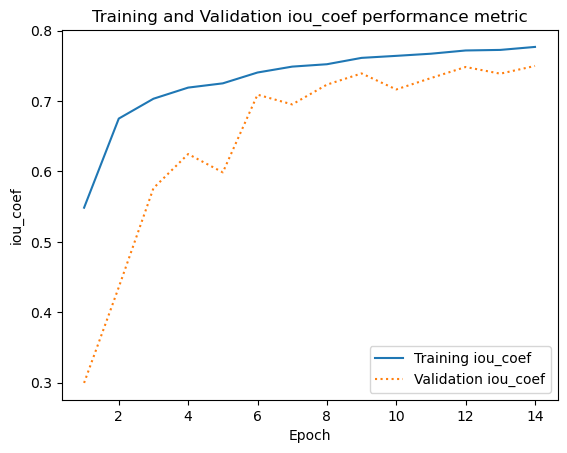

NameError: name 'name' is not defined

In [27]:
%%time
# Training the U-NET baseline model.
hist_model_unet = training_model(
    model=unet_model, name='model_unet', 
    train_gen=train_generator, val_gen=val_generator,
    loss=dice_loss, 
    metrics=[iou_coef]
)

<h4><div class="alert alert-block alert-warning" id="section_2A3">
3 - Visualization</div></h4>

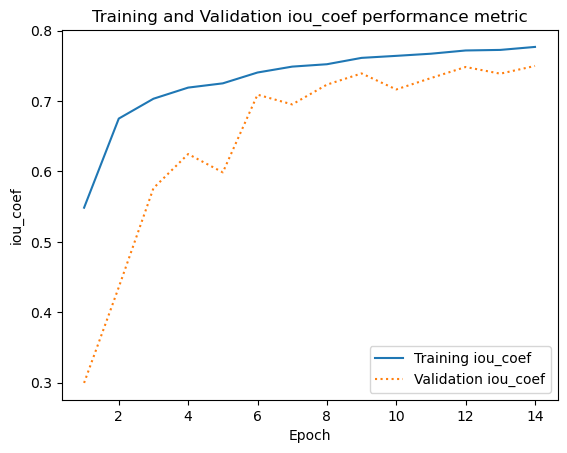

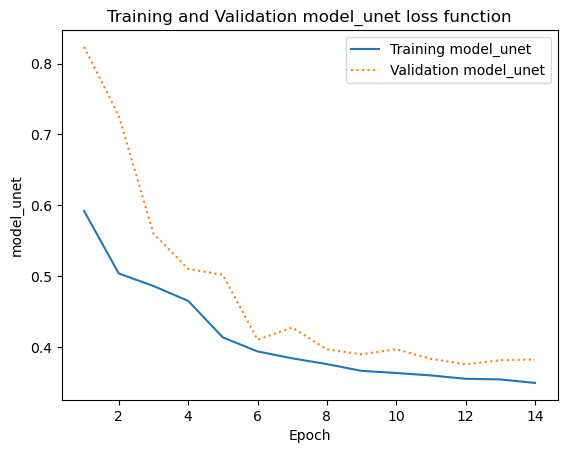

In [32]:
# Visualization of the Training and Validation with the iou_coef as performance metric.
metrics_visu(hist_model_unet, 'iou_coef')
# Visualization of the Training and Validation with the selected loss function.
loss_visu(hist_model_unet, 'model_unet')

<h3><div class="alert alert-block alert-info" id="section_2B">
B - STATE-OF-THE-ART MODEL</div></h3>

<h4><div class="alert alert-block alert-warning" id="section_2B1">
1 - Building the model</div></h4>

<h4><div class="alert alert-block alert-warning" id="section_2B2">
2 - Training the model</div></h4>

<h4><div class="alert alert-block alert-warning" id="section_2B3">
3 - Visualization</div></h4>

<h3><div class="alert alert-block alert-info" id="section_2C">
C - MODELS PERFORMANCE SUMMARY AND MODEL CHOICE</div></h3>

|Model|Validation IoU coef|Wall Time|
|:--|:-:|:-:|
|<div style="background: blue; color: white">***unet***</div>|<div style="background: blue; color: white">0.8298</div>|NC|
|<div style="background: green; color: white">***unet_resnet50***</div>|<div style="background: green; color: white">0.8373</div>|1h44|

After all the model testing, we can see the performance metrics in the above table.<br><br>
**The best** results are with the **UNET Resnet50 model**, **the worse** but still very good with the **Linknet VGG16 model**.<br>
Our **homemade UNET model** came good **second**, with a **very good performance**.<br><br>
Choosing between the two best models, **we will stay with our homemade UNET model** which was actually much more than a baseline. Also, part of the choice, the UNET Resnet50 model weighs 443 MO as **our UNET model only weighs 94 MO**.<br><br>
Our UNET model will be used for predicting the masks below, and for implementation in the REST API.

One last thing must be said. We are **disappointed by the results with data augmentation**. This is maybe because the transformations, like rotation for example, were too drastic and didn't help the models to improve.<br><br>But finally, **without data augmentation the results are very good**, and let's see what it looks like with real images. 

<h2><div class="alert alert-block alert-success" id="section_3">
PART 3 - MASK PREDICTIONS</div></h2>

<h3><div class="alert alert-block alert-info" id="section_3A">
A - SOME RANDOM MASK PREDICTIONS</div></h3>

In [33]:
def get_colored(pred_mask, n_classes):
    """Function to get the prediction mask colored as wanted 
    for the different 8 classes."""
    # This color map has been used to display the results in the predicted mask.
    color_map = {
        0: (0, 0, 0),        # void (black)
        1: (160, 120, 50),   # flat (brown)
        2: (255, 200, 200),  # construction (pink)
        3: (255, 255, 120),  # object (yellow)
        4: (0, 150, 40),     # nature (green)
        5: (0, 180, 230),    # sky (sky blue)
        6: (255, 80, 80),    # human (red)
        7: (90, 40, 210)     # vehicule (blue purple)
    }
    
    mask_height = pred_mask.shape[0]
    mask_width = pred_mask.shape[1]
    pred_mask_cls = np.zeros((mask_height, mask_width, 3))

    for cls in range(n_classes):
        pred_mask_rgb = pred_mask[:, :] == cls
        pred_mask_cls[:, :, 0] += (
            (pred_mask_rgb) * (color_map[cls][0])).astype('uint8') # R
        pred_mask_cls[:, :, 1] += (
            (pred_mask_rgb) * (color_map[cls][1])).astype('uint8') # G
        pred_mask_cls[:, :, 2] += (
            (pred_mask_rgb) * (color_map[cls][2])).astype('uint8') # B

    return pred_mask_cls.astype('uint8')

In [34]:
def mask_prediction(model, img_to_predict, gt_mask):
    """Function that makes the mask prediction with an image.
    Printing of the image, the ground truth mask and the colored prediction mask."""
    
    img_resized = cv2.resize(img_to_predict, (IMG_WIDTH, IMG_HEIGHT))
    pred_mask = model.predict(np.expand_dims(img_resized, axis=0))
    mask = np.squeeze(gt_mask)
    
    pred_mask = np.argmax(pred_mask, axis=-1)
    pred_mask = np.expand_dims(pred_mask, axis=-1)
    pred_mask = np.squeeze(pred_mask)
    pred_mask_colored = get_colored(pred_mask, 8)
    
    # Visualization of the image, the ground truth mask and the prediction mask.
    fig = plt.figure(figsize=(16, 16))
    ax = fig.add_subplot(1, 3, 1)
    ax.set_title('Image')
    ax.imshow(img_to_predict)
    
    ax1 = fig.add_subplot(1, 3, 2)
    ax1.set_title('GT_Fine_LabelIds_Mask')
    ax1.imshow(mask)
    ax1.axis('off')
    
    ax2 = fig.add_subplot(1, 3, 3)
    ax2.set_title('Mask prediction')
    ax2.imshow(pred_mask_colored)
    
    return pred_mask_colored

In [35]:
def run_prediction(img_paths, msk_paths, model):
    """Predicting the mask of 3 random images from a dataset."""
    # Getting 3 random indexes.
    i = random.randint(0, len(img_paths))
    j = random.randint(0, len(img_paths))
    k = random.randint(0, len(img_paths))
    print("i, j, k ", i, j, k)
    # Getting the images and the masks with these indexes in the paths.
    for n in [i, j, k]:
        print("n ", n)
        img_to_predict = img_to_array(
            load_img(img_paths[n])) / 255.0
        gt_mask = img_to_array(
            load_img(msk_paths[n], color_mode="grayscale"))
        gt_mask = np.squeeze(gt_mask)
        mask_prediction(model, img_to_predict, gt_mask)

In [37]:
# Loading our selected homemade UNET model.
model = load_model("models/model_unet", compile=False)

Predicting the mask of 3 random images from the train dataset:


i, j, k  2144 213 991
n  2144
1/1 [==============================] - 0s 373ms/step
n  213
1/1 [==============================] - 0s 30ms/step
n  991
1/1 [==============================] - 0s 13ms/step


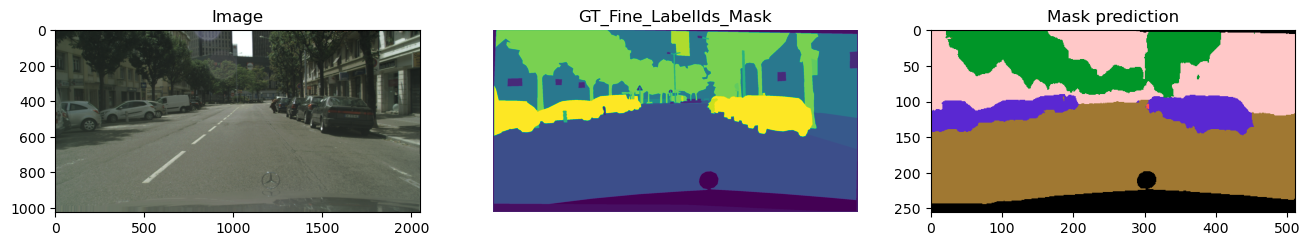

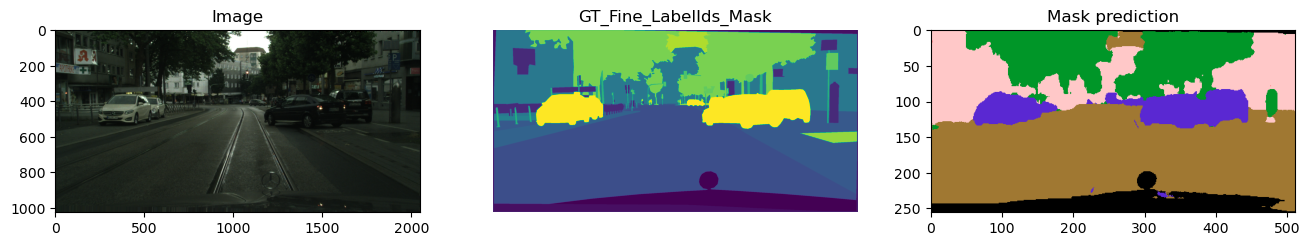

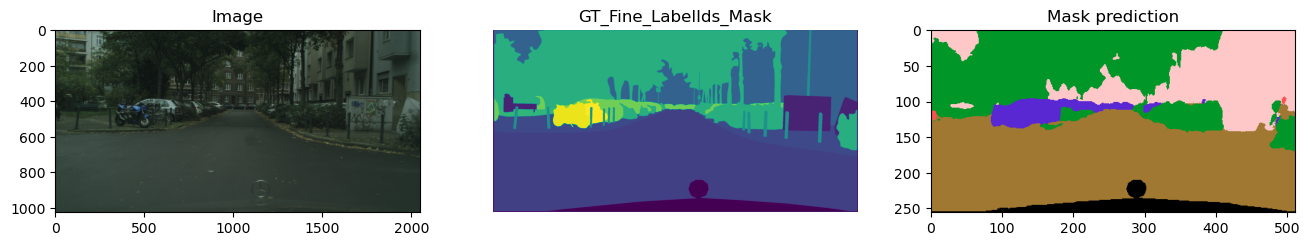

In [38]:
# Predicting the mask of 3 random images from the train dataset.
print("\033[34;1mPredicting the mask of 3 random images from the train dataset:\n\n")
run_prediction(image_train_paths, mask_train_paths, model)

Predicting the mask of 3 random images from the validation dataset:


i, j, k  367 250 211
n  367
1/1 [==============================] - 0s 14ms/step
n  250
1/1 [==============================] - 0s 16ms/step
n  211
1/1 [==============================] - 0s 14ms/step


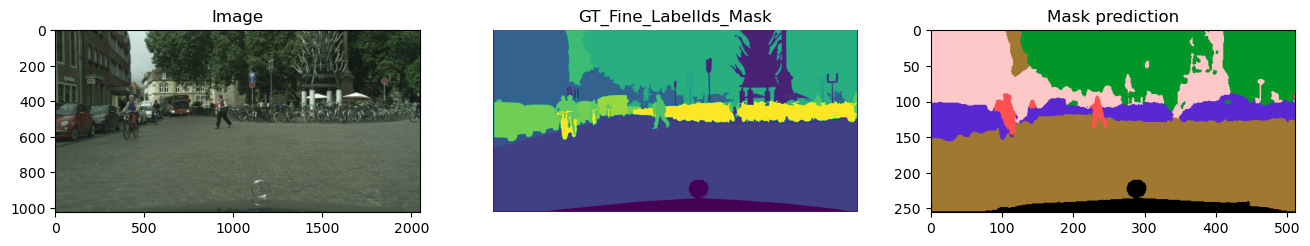

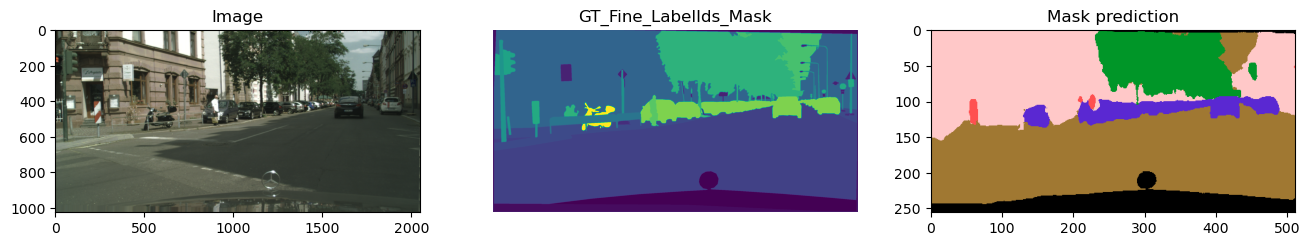

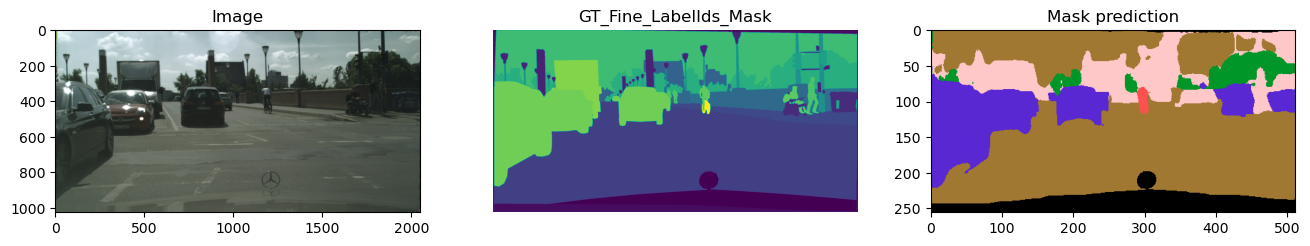

In [39]:
# Predicting the mask of 3 random images from the validation dataset.
print("\033[34;1mPredicting the mask of 3 random images from the validation dataset:\n\n")
run_prediction(image_val_paths, mask_val_paths, model)

In [40]:
# Predicting the mask of 3 random images from the test dataset.
print("\033[34;1mPredicting the mask of 3 random images from the test dataset:\n\n")
run_prediction(image_test_paths, mask_test_paths, model)

Predicting the mask of 3 random images from the test dataset:


i, j, k  1505 4 610
n  1505


IndexError: list index out of range

Those results seem very good to us, almost too good, but still some progress could be made.

<h3><div class="alert alert-block alert-info" id="section_3B">
B - WAYS TO IMPROVE THE RESULT</div></h3>

In order to improve the performance of the results, and therefore of our models, we can consider:<br><br>
• **A larger, more varied dataset**, with more images and masks.<br>
• Test with **other modern model architectures** such as Xception, SENet, ResNeXt, EfficientNet, PSPNet… or Transformers.<br>
• Transfer learning with **other backbones**.<br>
• **Fine-tune the Hyperparameter**.<br>

For the tuning of the hyperparameters, we can play here on the following points:<br>
• <b>Batch size</b>: the number of training images in one forward or backward pass.<br>
• <b>Iterations</b>: the number forward or backward of passes.<br>
• <b>Epoch</b>: measures how many times every image has been seen during training. It can be also understood as a one forward pass and one backward pass of all the training examples.<br>
• <b>Loss function</b>: evaluates the penalty between the prediction and the ground truth label in every batch.<br>
• <b>Learning rate</b>: defines the step size for which the weights of a model are updated regarding the stochastic gradient descent.<br>
• <b>Optimizer</b>: to find the most optimal set of hyperparameters for the model (SGD, RMSprop, Adam, etc.).

Moreover, we can also  **change the weight of theclass indexes we want to prioritise** for the performance. For example, it should be more important to detect humans (class 6) or vehicules (class 7) than the sky (class 5) or the void (class 0).

Finally, as for the U-NET architecture, we could also have tested to put **SeparableConv2D** instead of Conv2D layers after the first Conv2D layer (because of the RGB).

<img src="img_notebook/logo_dataspace.png" width="350" height="350">